In [2]:
import json
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import os
import pickle
import pandas as pd
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC, LinearSVC

In [13]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\oswaldoolivo\AppData\Roaming\nltk_data...


True

In [14]:
trainData = pd.read_csv('data/petfinder/train.csv')

In [15]:
trainData.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64


<AxesSubplot:>

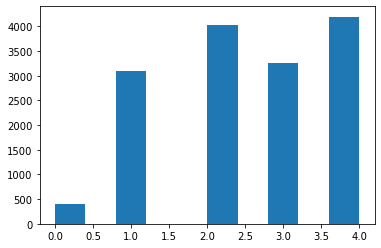

In [16]:
# Adoption speed label
print(trainData['AdoptionSpeed'].value_counts())
trainData['AdoptionSpeed'].hist(grid = False)

In [17]:
print("Total number of pets: ", len(trainData))
print("Total number of unnamed pets: ", sum(trainData['Name'].isna()))

Total number of pets:  14993
Total number of unnamed pets:  1257


In [18]:
trainData.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [36]:
# Convert description column to string.
trainData['Description'] = trainData['Description'].astype('string')

# Replace N/A by empty string.
trainData['Description'] = trainData['Description'].fillna ("")

# Add HasDescription column.
trainData['HasDescription'] = trainData['Description'] != ""

# Add DescriptionLength column.
trainData['DescriptionLength'] = [len(x) for x in trainData['Description']]

In [41]:
# Adding sentiment features for description.

# Get sentiment dataframe.
def get_description_sentiment_dataframe():

    ids = []
    sentiment_magnitudes = []
    sentiment_scores = []
    
    path = 'data/petfinder/train_sentiment'
    fileList = os.listdir(path)
    
    for filename in fileList:
        file = open(os.path.join(path + '/' + filename), 'r', encoding="utf8")
        
        sentiment = json.load(file)
        
        id = filename.split(".")[0]
        sentiment_magnitude = float(sentiment['documentSentiment']['magnitude'])
        sentiment_score = float(sentiment['documentSentiment']['score'])
        
        ids.append(id)
        sentiment_magnitudes.append(sentiment_magnitude)
        sentiment_scores.append(sentiment_score)
        
    d = {"id": ids, "sentiment_magnitude": sentiment_magnitudes, "sentiment_score": sentiment_scores }
    df = pd.DataFrame(d)
    
    return df
        
sentiment_df = get_description_sentiment_dataframe()
sentiment_df.head(10)

,id,sentiment_magnitude,sentiment_score
0,0008c5398,2.8,0.7
1,000a290e4,0.6,0.3
2,000fb9572,0.8,0.3
3,0011d7c25,0.8,0.8
4,00156db4a,1.8,0.0
5,001a1aaad,3.5,0.2
6,001b1507c,4.7,0.3
7,002230dea,2.0,0.4
8,002278114,11.4,0.1
9,0038234c6,3.0,0.3


In [42]:
# Merging sentiment dataframe with main dataframe.
trainData = trainData.merge(sentiment_df, left_on='PetID', right_on='id', how='left')

In [43]:
# Adding sentiment product: (sentiment * magnitude) as a feature to dataframe.
trainData['SentimentProduct'] = trainData['sentiment_score']*trainData['sentiment_magnitude']

In [51]:
# Computing sentiment using NLTK's pre-trained analyzer.

def get_description_nltk_sentiment_analysis_dataframe():
    sia = SentimentIntensityAnalyzer()
    ids = trainData['PetID']
    descriptions = trainData['Description']
    
    negative_probs = []
    neutral_probs = []
    positive_probs = []
    compound_scores = []
    
    for description in descriptions:
        polarity_scores = sia.polarity_scores(description)
        
        negative_probs.append(polarity_scores['neg'])
        neutral_probs.append(polarity_scores['neu'])
        positive_probs.append(polarity_scores['pos'])
        compound_scores.append(polarity_scores['compound'])
    
    d = { "PetID": ids, "nltk_negative_prob": negative_probs, "nltk_neutral_prob": neutral_probs, \
          "nltk_positive_prob" : positive_probs, 'nltk_compound_score' : compound_scores}
    df = pd.DataFrame(d)
    
    return df
        
nltk_sentiment_df = get_description_nltk_sentiment_analysis_dataframe()

In [52]:
# Merge train dataframe with NLTK sentiment dataframe.
trainData = trainData.merge(nltk_sentiment_df, on='PetID', how='left')

trainData.head(10)

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,sentiment_magnitude,sentiment_score,nltk_negative_prob_y,nltk_neutral_prob_y,nltk_positive_prob_y,nltk_compound_score_y,nltk_negative_prob,nltk_neutral_prob,nltk_positive_prob,nltk_compound_score
0,2,Nibble,3.0,299,0,1,1,7,0,1,...,2.4,0.3,0.000,0.745,0.255,0.9552,0.000,0.745,0.255,0.9552
1,2,No Name Yet,1.0,265,0,1,1,2,0,2,...,0.7,-0.2,0.149,0.723,0.129,0.1280,0.149,0.723,0.129,0.1280
2,1,Brisco,1.0,307,0,1,2,7,0,2,...,3.7,0.2,0.095,0.706,0.200,0.7650,0.095,0.706,0.200,0.7650
3,1,Miko,4.0,307,0,2,1,2,0,2,...,0.9,0.9,0.000,0.483,0.517,0.9538,0.000,0.483,0.517,0.9538
4,1,Hunter,1.0,307,0,1,1,0,0,2,...,3.7,0.6,0.000,0.635,0.365,0.9880,0.000,0.635,0.365,0.9880
5,2,NaN,3.0,266,0,2,5,6,0,2,...,0.2,0.0,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000
6,2,BULAT,12.0,264,264,1,1,0,0,2,...,0.5,0.2,0.000,0.814,0.186,0.9116,0.000,0.814,0.186,0.9116
7,1,Siu Pak & Her 6 Puppies,0.0,307,0,2,1,2,7,2,...,0.9,0.1,0.000,0.818,0.182,0.4588,0.000,0.818,0.182,0.4588
8,2,NaN,2.0,265,0,2,6,0,0,2,...,0.5,0.1,0.113,0.576,0.311,0.5327,0.113,0.576,0.311,0.5327
9,2,Kitty,12.0,265,0,2,1,7,0,2,...,1.1,0.2,0.000,0.751,0.249,0.8916,0.000,0.751,0.249,0.8916


In [53]:
trainData.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'HasDescription', 'id_x', 'sentiment_magnitude_x', 'sentiment_score_x',
       'SentimentProduct', 'nltk_negative_prob_x', 'nltk_neutral_prob_x',
       'nltk_positive_prob_x', 'nltk_compound_score_x', 'DescriptionLength',
       'id_y', 'sentiment_magnitude_y', 'sentiment_score_y', 'id',
       'sentiment_magnitude', 'sentiment_score', 'nltk_negative_prob_y',
       'nltk_neutral_prob_y', 'nltk_positive_prob_y', 'nltk_compound_score_y',
       'nltk_negative_prob', 'nltk_neutral_prob', 'nltk_positive_prob',
       'nltk_compound_score'],
      dtype='object')

In [54]:
categoricalFeatures = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', \
                       'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', \
                       'Sterilized', 'Health', 'State', 'HasDescription']

numericalFeatures = ['Age', 'Quantity', 'Fee', 'VideoAmt',  'PhotoAmt', 'DescriptionLength',\
                    #'sentiment_magnitude', 'sentiment_score', 'SentimentProduct',\
                    'nltk_positive_prob', 'nltk_negative_prob', 'nltk_neutral_prob',\
                    'nltk_compound_score']

features = categoricalFeatures + numericalFeatures

In [55]:
# Transforming columns.
labelEncoder = sklearn.preprocessing.LabelEncoder()
trainData['AdoptionSpeed'] = labelEncoder.fit_transform(trainData['AdoptionSpeed'])
    
# Transform features into categorical.
for c in categoricalFeatures:
        trainData[c] = trainData[c].astype('category')
        
# Transform features into float.
for c in numericalFeatures:
        trainData[c] = trainData[c].astype('float')
        
# Fill N/A values with zero for sentiment
trainData = trainData.fillna(value={'sentiment_magnitude': 1, 'sentiment_score': 1, 'SentimentProduct': 1})

In [56]:
# Splitting into train and test set.
x_train, x_test, y_train, y_test = train_test_split(trainData[features], trainData['AdoptionSpeed'], \
                                                    test_size=0.33, shuffle=True)

In [57]:
# Training a decision tree classifier for testing.
decisionTree = sklearn.tree.DecisionTreeClassifier(random_state=0)

decisionTree.fit(x_train, y_train)
        
decisionTreePredictions = decisionTree.predict(x_test)

print("F1 Score:", f1_score(y_test, decisionTreePredictions, average='macro'))
print("Accuracy Score:", accuracy_score(y_test, decisionTreePredictions))
print("Recall Score:", recall_score(y_test, decisionTreePredictions, average='macro'))

F1 Score: 0.29255225263126766
Accuracy Score: 0.33104284559417946
Recall Score: 0.29319622748122126


In [64]:
#Function for training a model.
def train_model(model):
    trained_model = Pipeline([
        #('feature_selection', SelectFromModel(estimator=sklearn.tree.DecisionTreeClassifier(random_state=0))),
        ('classification', model)
    ])
    trained_model.fit(x_train, y_train)
    
    return trained_model

# Function for training and outputing test results for a model.
def train_and_test_model(model):
    
    trained_model = train_model(model)
    predictions = trained_model.predict(x_test)
    
    print("F1 Score:", f1_score(y_test, predictions, average='macro'))
    print("Accuracy Score:", accuracy_score(y_test, predictions))
    print("Recall Score:", recall_score(y_test, predictions, average='macro'))
    
    if hasattr(trained_model, 'feature_importances_'):
        print("Feature Importances: ")
        for feature, importance in zip(features, trained_model.feature_importances_):
            print('feature: {f}, importance: {i}'.format(f=feature, i=importance))
    print()
    

# Function for training and outputing test results for a collection of models.
def train_and_test_model_collection(models):
    for model_name, model in models.items():
        print("Training and testing model:", model_name)
        train_and_test_model(model)
        print("=====")

In [65]:
# Training and testing multiple models.
model_collection = { 'Decision Tree' : sklearn.tree.DecisionTreeClassifier(random_state=0), \
                     'Support Vector Machine' : sklearn.svm.SVC(decision_function_shape='ovr'), \
                     'Bernoulli Naive Bayes' : BernoulliNB(), \
                     'Gaussian Naive Bayes' : GaussianNB(), \
                     'Multi-layer Perceptron Classifier' : MLPClassifier(random_state = 0), \
                     'KNN Classifier' : KNeighborsClassifier(n_neighbors=6), \
                     'Bagging Extra Tree Classifier' : BaggingClassifier(ExtraTreeClassifier(random_state=0), random_state=0), \
                     'Random Forest Classifier' : RandomForestClassifier(max_depth=20, random_state=0), \
                     'Gradient Boosting Classifier' : GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, \
                                                                                 max_depth=10, random_state=0), \
                     'Ada Boost Classifier' : AdaBoostClassifier(n_estimators=100, random_state=0),
                     'Bagging Classifier (Decision Trees)' : BaggingClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(random_state=0), n_estimators=10, random_state=0)}

train_and_test_model_collection(model_collection)

Training and testing model: Decision Tree
F1 Score: 0.29255225263126766
Accuracy Score: 0.33104284559417946
Recall Score: 0.29319622748122126

=====
Training and testing model: Support Vector Machine
F1 Score: 0.08618994767718409
Accuracy Score: 0.27465642683912694
Recall Score: 0.2

=====
Training and testing model: Bernoulli Naive Bayes
F1 Score: 0.17319376231582467
Accuracy Score: 0.2890056588520614
Recall Score: 0.21500034099068688

=====
Training and testing model: Gaussian Naive Bayes
F1 Score: 0.2613717684441881
Accuracy Score: 0.3104284559417947
Recall Score: 0.2764800417901281

=====
Training and testing model: Multi-layer Perceptron Classifier


C:\Users\oswaldoolivo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\oswaldoolivo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\Users\oswaldoolivo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to nume

F1 Score: 0.10289118486183554
Accuracy Score: 0.27910266774454323
Recall Score: 0.205627754828463

=====
Training and testing model: KNN Classifier
F1 Score: 0.26486825328370733
Accuracy Score: 0.3179062247372676
Recall Score: 0.2667322643502847

=====
Training and testing model: Bagging Extra Tree Classifier
F1 Score: 0.3106680618016223
Accuracy Score: 0.3593371059013743
Recall Score: 0.30466053454856257

=====
Training and testing model: Random Forest Classifier
F1 Score: 0.3263681819285088
Accuracy Score: 0.408447857720291
Recall Score: 0.3304087452968054

=====
Training and testing model: Gradient Boosting Classifier
F1 Score: 0.32712044772872334
Accuracy Score: 0.3841956345998383
Recall Score: 0.3240332416360722

=====
Training and testing model: Ada Boost Classifier
F1 Score: 0.29373399943849293
Accuracy Score: 0.3896523848019402
Recall Score: 0.3075403306469985

=====
Training and testing model: Bagging Classifier (Decision Trees)
F1 Score: 0.3132697646692516
Accuracy Score: 0.3

In [66]:
# Utility function for saving a model with pickle.
def save_pickle_model(model_filename, model):
    pickle.dump(model, open(model_filename, 'wb'))

In [67]:
# Save a sample random forest classifier.
save_pickle_model("models/random_forest_classifier_test.pkl", train_model(RandomForestClassifier(max_depth=20, random_state=0)))